In [87]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn.preprocessing import normalize

In [88]:
import tensorflow as tf
session = tf.Session()

## carga de los datos desde url y transformacion a CSV

In [89]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat"
birth_file = requests.get(url) 
birth_data = birth_file.text.split("\r\n") ##separa cada fila del dataset

birth_header = birth_data[0].split("\t") ##cabecera del dataset
birth_data = [[float(x) for x in y.split("\t") if len(x)>=1] for y in birth_data[1:] if len(y)>=1] ##con esta linea se obtiene los datos limpios fila por fila

In [90]:
import os.path
import csv

birthweigt_file_name = "birthweight.csv"
if not os.path.exists(birthweigt_file_name):
    with open("birthweight.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

In [91]:
birth_header

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']

In [92]:
birth_data[0]

[1.0, 28.0, 113.0, 1.0, 1.0, 1.0, 0.0, 1.0, 709.0]

In [93]:
x_vals = np.array([x[1:8] for x in birth_data]) ##variables predictoras
y_vals = np.array([x[0] for x in birth_data])   ##variable a predecir

## Dividir en conjunto de entrenamiento y test

In [94]:
train_index =np.random.choice(len(x_vals), size=round(len(x_vals)*0.8), replace=False)
test_index = np.array(list(set(range(len(x_vals)))-set(train_index)))

In [95]:
x_vals_train = x_vals[train_index]
x_vals_test = x_vals[test_index]

y_vals_train = y_vals[train_index]
y_vals_test = y_vals[test_index]

## Normalizacion del dataset
    -En la regresion logistica es importante normalizar el dataset, para que la funcion logistica converga.
    
    -LA NORMALIZACION hace que los valores del dataset queden escalados entre 0 y 1; de modo que el valor mas pequeño del dataset se convierte en 0 y el valor mas grande del dataset se convierte en 1

In [96]:
def normalize_cols(m, col_min = np.array([None]), col_max=np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return (m-col_min)/(col_max-col_min), col_min, col_max

In [97]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))

In [98]:
x_vals_train[0]

array([0.13636364, 0.29411765, 1.        , 1.        , 1.        ,
       0.        , 1.        ])

In [99]:
train_min

array([14., 80.,  0.,  0.,  0.,  0.,  0.])

In [100]:
train_max 

array([ 36., 250.,   1.,   1.,   1.,   1.,   1.])

In [101]:
x_vals_test,_,_ = np.nan_to_num(normalize_cols(x_vals_test, col_min=train_min, col_max=train_max))

## se declaran los placeholders

In [102]:
x_data = tf.placeholder(shape=[None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype=tf.float32)

## se declaran las variables

In [103]:
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

## creacion del modelo

In [104]:
prediccion = tf.add(tf.matmul(x_data, A), b)

## se define la funcion de perdida

In [105]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediccion, labels= y_target))
init = tf.global_variables_initializer()
session.run(init)
optimizador = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_step = optimizador.minimize(loss)

## funcion de clasificacion logistica

In [106]:
classification_logistica = tf.round(tf.sigmoid(prediccion)) ## si el valor de la sigmoide devuelve menor a 0.5 la funcion "round" lo convierte a 0, y si el valor de la sigmoide devuelve mayor a 0.5 la funcion "round" lo convierte a 1
correct_classification = tf.cast(tf.equal(classification_logistica, y_target), tf.float32) ## la funcion "cast" devuelve el numero de aciertos
accuracy = tf.reduce_mean(correct_classification) ## saca el porcentaje de aciertos con respecto al total de los datos

## se define el batch_size

In [107]:
batch_size = 25

## inicializar las variables

In [108]:
init = tf.global_variables_initializer()
session.run(init)

## entrenamiento del modelo

In [109]:
loss_vec = []
train_acc = []
test_acc = []
for i in range(2000):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = session.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = session.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if(i+1)%100==0:
        print("Loss: "+str(temp_loss)+"  acc: "+str(temp_acc_test))

Loss: 1.1328018  acc: 0.2631579
Loss: 1.0432291  acc: 0.2631579
Loss: 0.7363588  acc: 0.28947368
Loss: 0.75022286  acc: 0.36842105
Loss: 0.63592374  acc: 0.39473686
Loss: 0.6516742  acc: 0.47368422
Loss: 0.7021424  acc: 0.5263158
Loss: 0.60038835  acc: 0.6052632
Loss: 0.6061051  acc: 0.6315789
Loss: 0.55894566  acc: 0.65789473
Loss: 0.5921131  acc: 0.65789473
Loss: 0.69061226  acc: 0.65789473
Loss: 0.54885536  acc: 0.68421054
Loss: 0.70288885  acc: 0.7105263
Loss: 0.7162949  acc: 0.7368421
Loss: 0.564473  acc: 0.7368421
Loss: 0.59004855  acc: 0.7368421
Loss: 0.48189086  acc: 0.7105263
Loss: 0.63148355  acc: 0.7105263
Loss: 0.6248349  acc: 0.7368421


In [110]:
## se obtienen los valores de "A" y de "b"
slope = session.run(A)
[[intercept]] = session.run(b)

In [111]:
slope

array([[ 0.45411566],
       [-1.0069288 ],
       [ 0.14243796],
       [ 0.799734  ],
       [-0.19389594],
       [ 0.33405358],
       [ 0.29859313]], dtype=float32)

In [112]:
print(str(slope[0][0])+"x1 + "+str(slope[1][0])+"x2 + "+str(slope[2][0])+"x3 + "+str(slope[3][0])+"x4 + "+str(slope[4][0])+"x5 + "+str(slope[5][0])+"x6 + "+str(slope[6][0])+"x7 + "+str(intercept))

0.45411566x1 + -1.0069288x2 + 0.14243796x3 + 0.799734x4 + -0.19389594x5 + 0.33405358x6 + 0.29859313x7 + -0.98994595


## grafico que muestra como fue convergiendo la funcion de perdidas

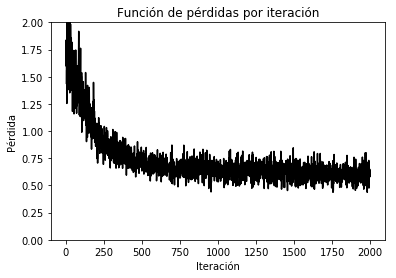

In [113]:
plt.plot(loss_vec, 'k-')
plt.title("Función de pérdidas por iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.ylim([0,2])
plt.show()

## grafico que muestra la precision del modelo con el conjunto de entrenamiento y en el conjunto de testing

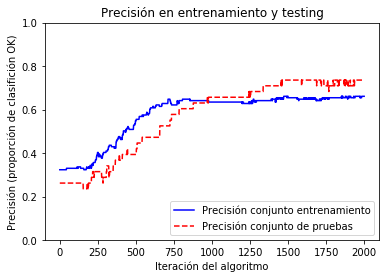

In [114]:
plt.plot(train_acc, 'b-', label = "Precisión conjunto entrenamiento")
plt.plot(test_acc, 'r--', label = "Precisión conjunto de pruebas")
plt.title("Precisión en entrenamiento y testing")
plt.xlabel("Iteración del algoritmo")
plt.ylabel("Precisión (proporción de clasifición OK)")
plt.legend(loc = 'lower right')
plt.ylim([0,1])
plt.show()

In [115]:
cant_clasificaciones_correctas = session.run(correct_classification, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})

In [116]:
print(cant_clasificaciones_correctas.sum()/len(y_vals_test)) ##porcentaje de elementos bien clasificados

0.7368421052631579
